### Try Contagion map on single-cell expression matrix

### First we do the scanpy tutorial

In [1]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [2]:
%load_ext autoreload
%autoreload 2

import cmap


import numpy as np
import pandas as pd
import scanpy as sc
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 pynndescent==0.5.5


In [4]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results


In [5]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True) 

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Preprocessing

normalizing counts per cell
    finished (0:00:00)


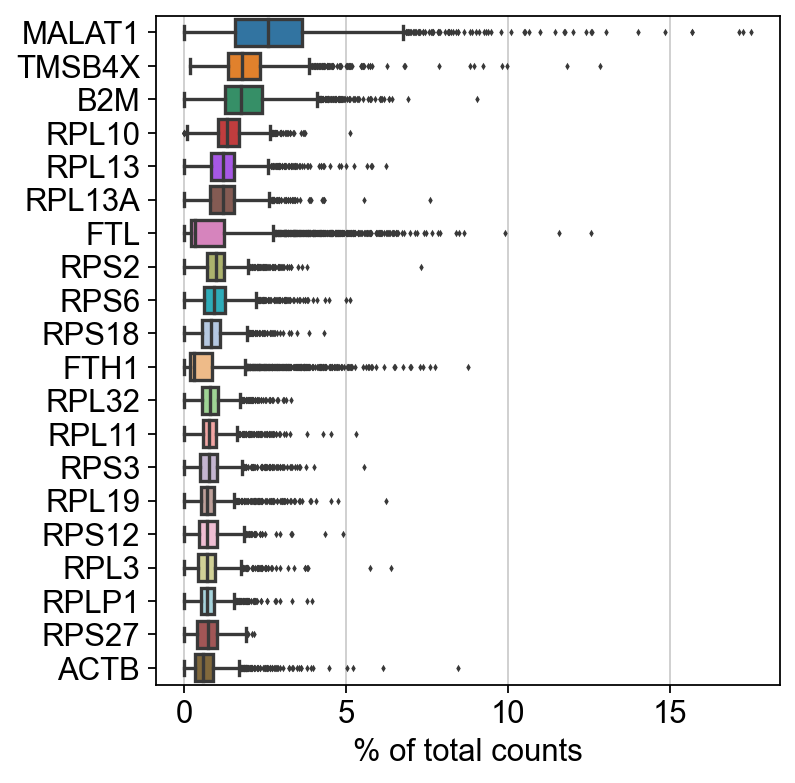

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

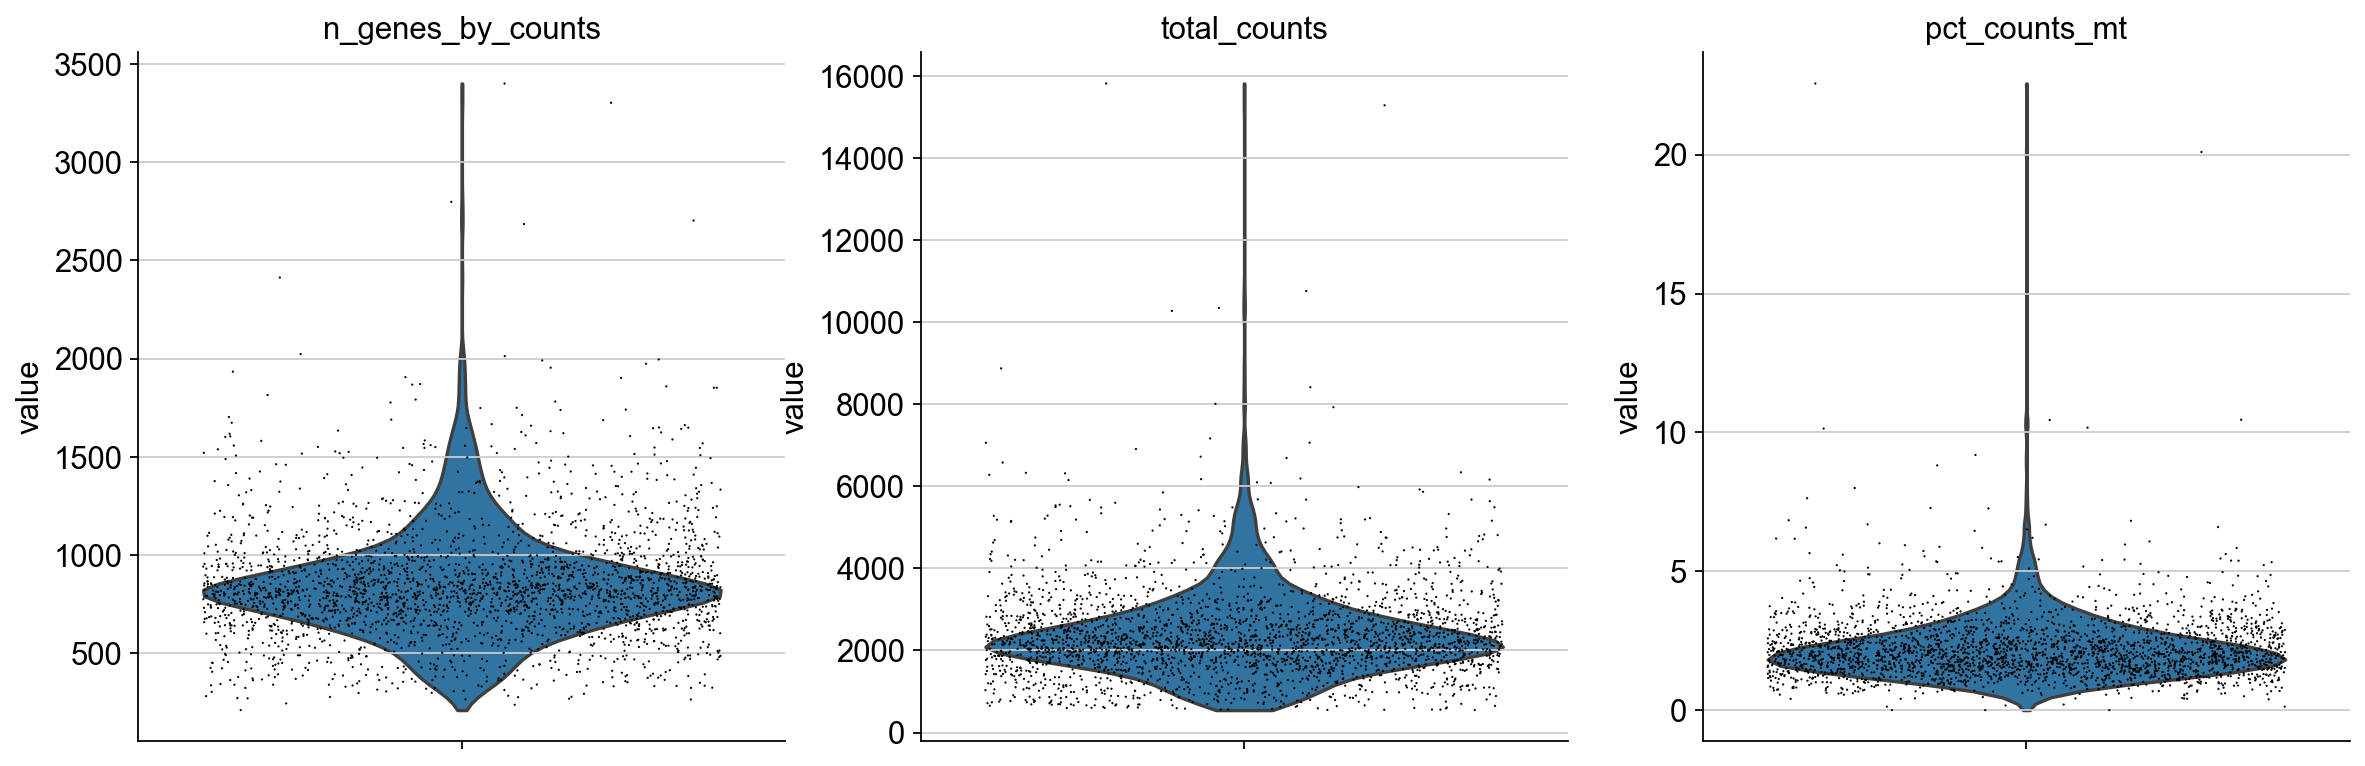

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

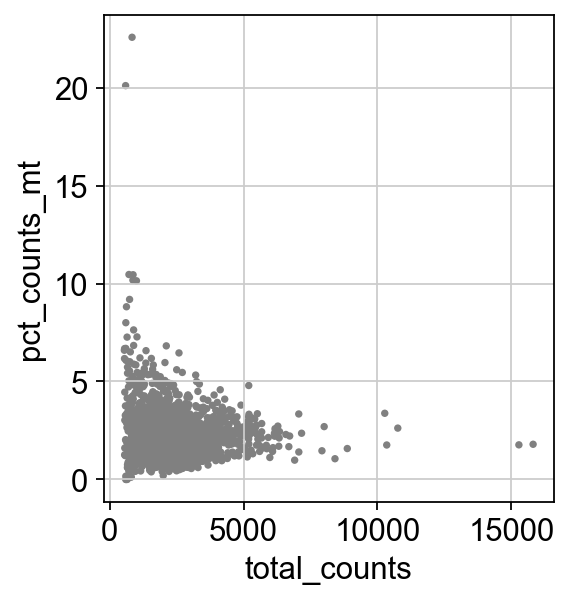

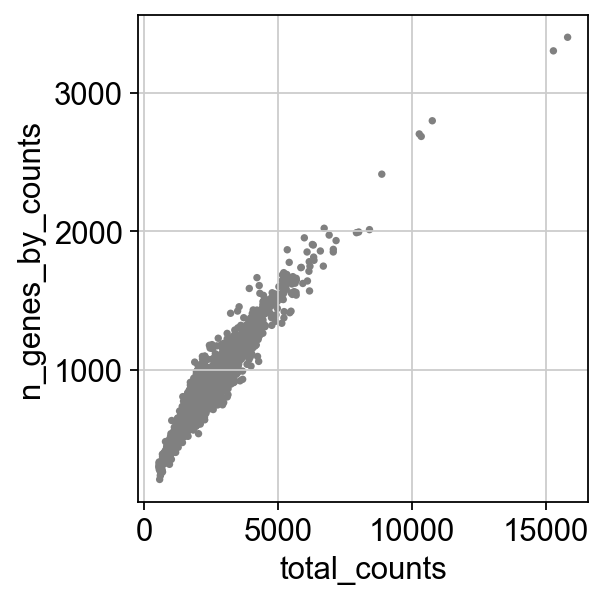

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)


normalizing counts per cell
    finished (0:00:00)


/Users/fklimm/mambaforge/envs/contagionMap/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
sc.pp.log1p(adata)


In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


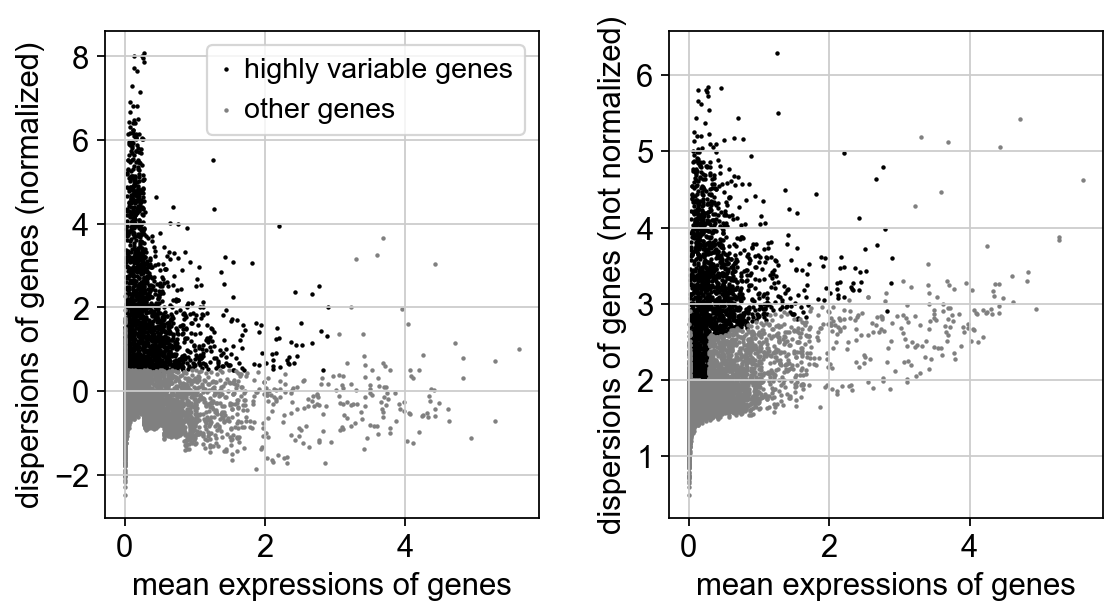

In [17]:
sc.pl.highly_variable_genes(adata)


In [18]:
adata.raw = adata


In [19]:
adata = adata[:, adata.var.highly_variable]


In [20]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


In [21]:
sc.pp.scale(adata, max_value=10)


### Principal component analysis

In [22]:
sc.tl.pca(adata, svd_solver='arpack')


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


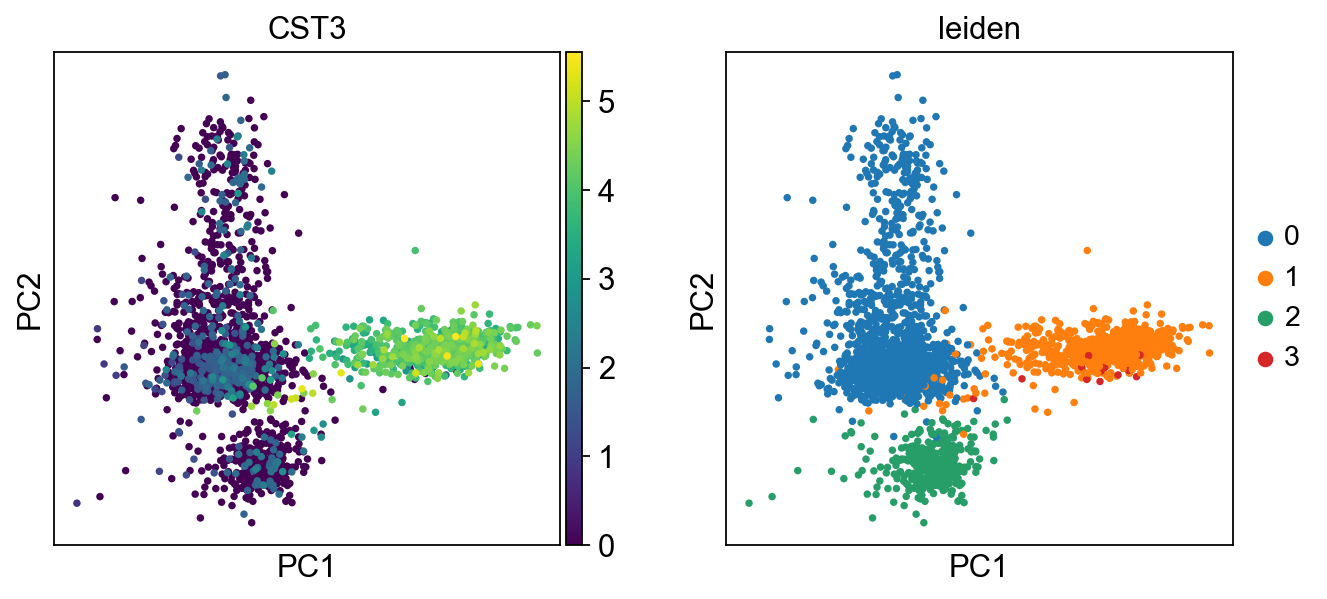

In [54]:
sc.pl.pca(adata, color=['CST3','leiden'])


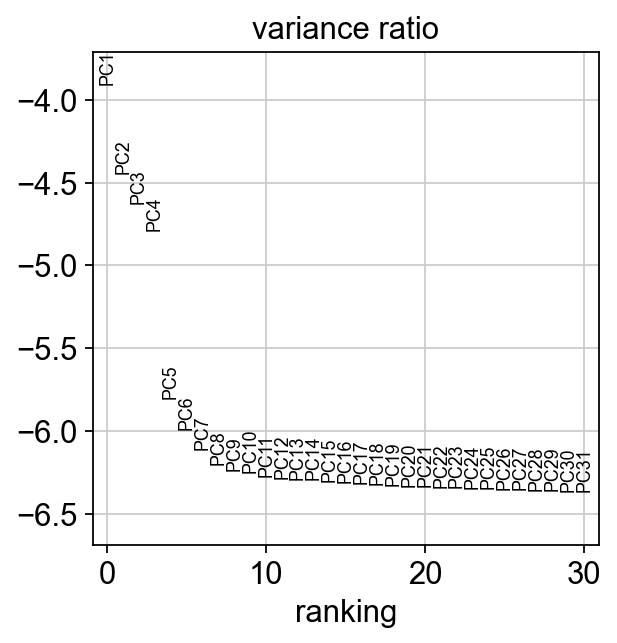

In [24]:
sc.pl.pca_variance_ratio(adata, log=True)


In [25]:
adata.write(results_file)


In [26]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### UMAP and neighbourhood graph

In [72]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [73]:
# sc.tl.paga(adata)
# pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
# tl.umap(adata, init_pos='paga')

In [74]:
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=1.0)



computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


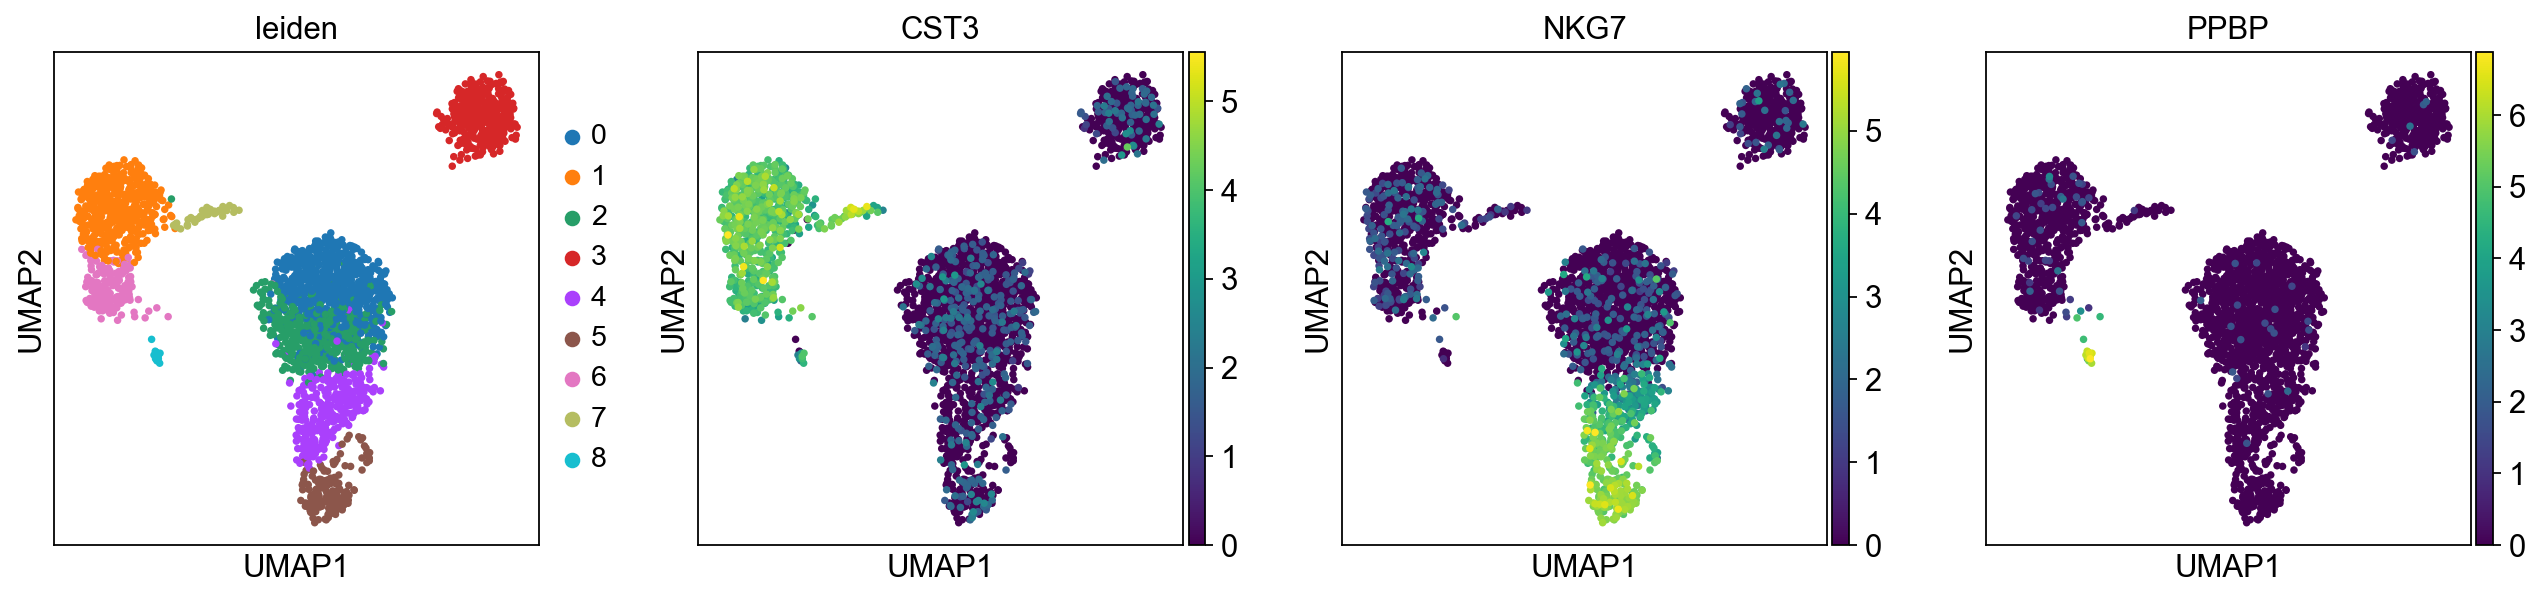

In [75]:
sc.pl.umap(adata, color=['leiden','CST3', 'NKG7', 'PPBP'])


### Contagion map in comparison

In [45]:
binarisedMatrix = adata.obsp['connectivities']
binarisedMatrix[binarisedMatrix>0] = 1
neighbourhoodGraph = nx.from_numpy_matrix(binarisedMatrix)

In [46]:
t=0.5

#contagionMapSingleCell = cmap.runTruncatedContagionMap(neighbourhoodGraph,threshold=t,numberSteps=np.Inf,symmetric=False)

contagionMapSingleCell = cmap.runTruncatedContagionMap(neighbourhoodGraph,threshold=t,numberSteps=np.Inf,symmetric=True)

In [47]:
pca = PCA(n_components=2)
X_projected = pca.fit_transform(contagionMapSingleCell)

In [48]:
print(pca.explained_variance_ratio_)

[0.00963559 0.00890014]


<AxesSubplot:>

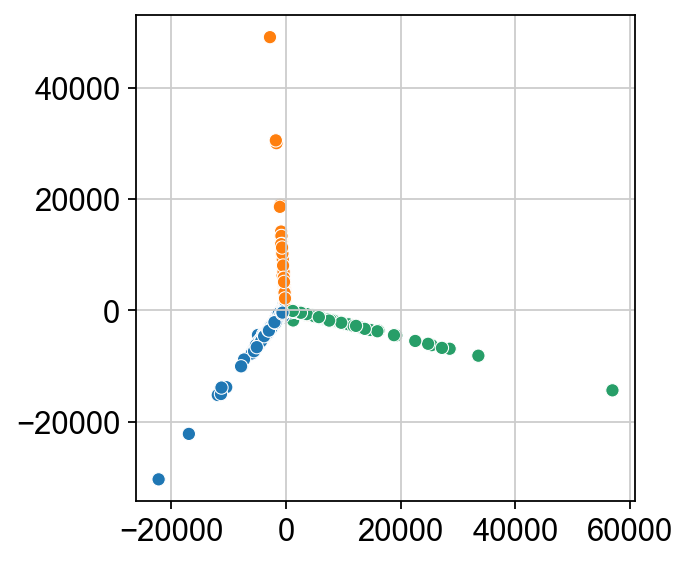

In [49]:
sns.scatterplot(x=X_projected[:,0],y=X_projected[:,1],hue=adata.obs['leiden'], legend = False)

### Run for a whole range of parameter values

FileNotFoundError: [Errno 2] No such file or directory: './figures/singleCell/resolution1Fine/SingleCellPlot_t0.14s9.pdf'

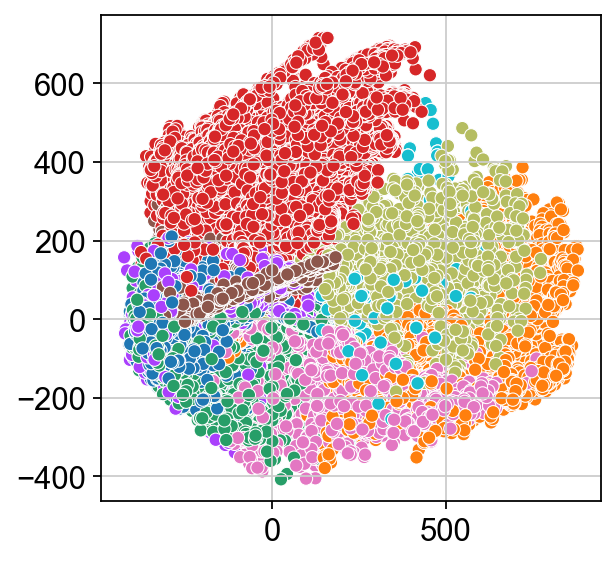

In [82]:
t_vec = np.arange(0.01,0.25,0.01)
s_vec = [i for i in range(1,10,1)]
s_vec.append(np.Inf)

for t in t_vec:
    for s in s_vec:


        contagionMapSingleCellTruncated = cmap.runTruncatedContagionMap(neighbourhoodGraph,threshold=t,numberSteps=s,symmetric=True)

        pca = PCA(n_components=2)
        X_projected_truncated = pca.fit_transform(contagionMapSingleCellTruncated)

        sns.scatterplot(x=X_projected_truncated[:,0],y=X_projected_truncated[:,1],hue=adata.obs['leiden'], legend = False)
        figname = './figures/singleCell/resolution1Fine/SingleCellPlot' + '_t' +  str(t) + 's'+ str(s) + '.pdf'
        plt.savefig(figname)

In [80]:
np.arange(0.01,0.45,0.05)

array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41])

In [63]:
t=0.1
s=10
contagionMapSingleCellTruncated = cmap.runTruncatedContagionMap(neighbourhoodGraph,threshold=t,numberSteps=s,symmetric=True)

/Users/fklimm/mambaforge/envs/contagionMap/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/fklimm/mambaforge/envs/contagionMap/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


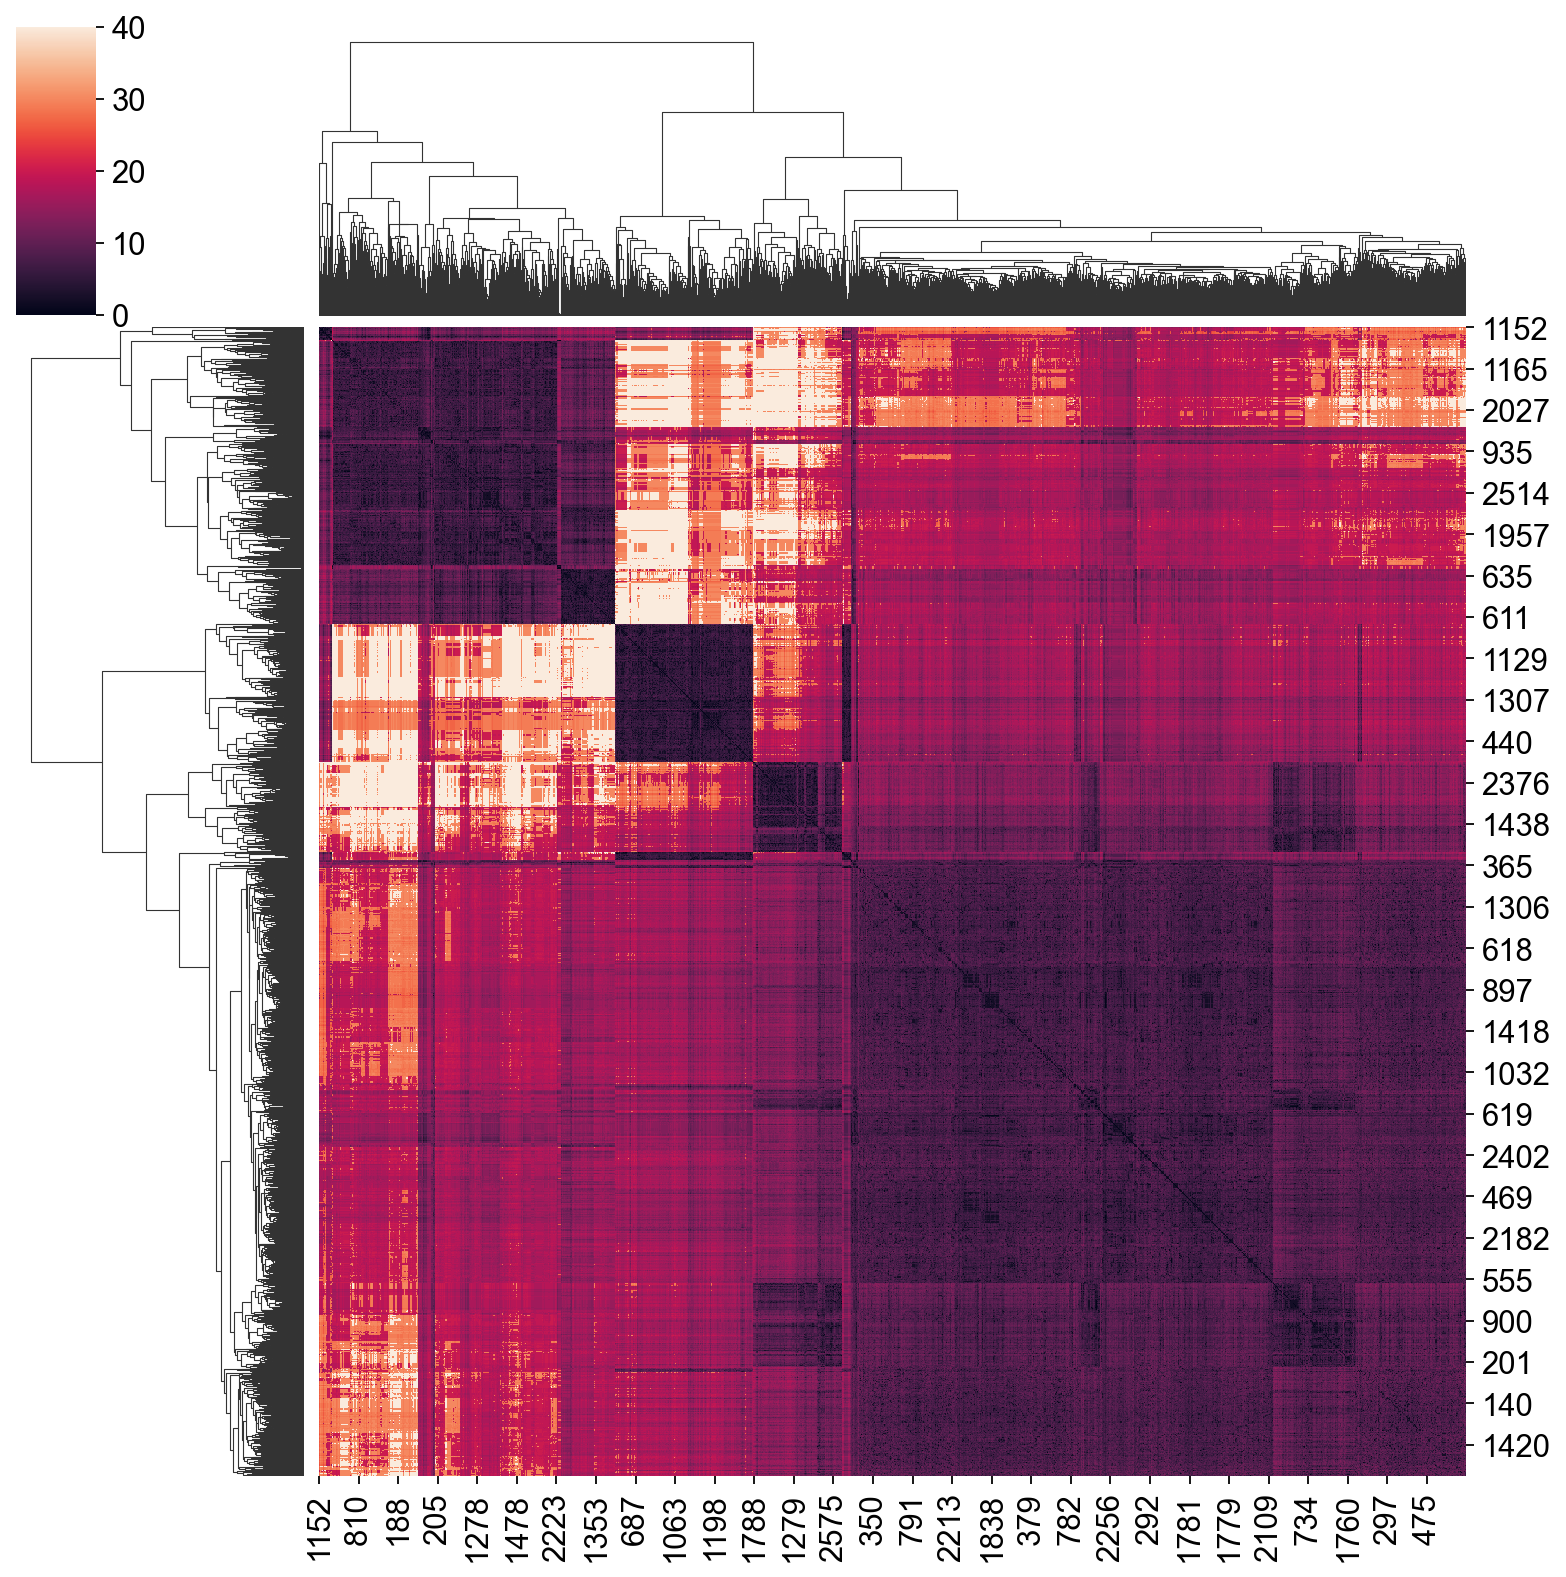

In [64]:
sns.clustermap(contagionMapSingleCellTruncated)

In [65]:
pca = PCA(n_components=2)
X_projected_truncated = pca.fit_transform(contagionMapSingleCellTruncated)

<AxesSubplot:>

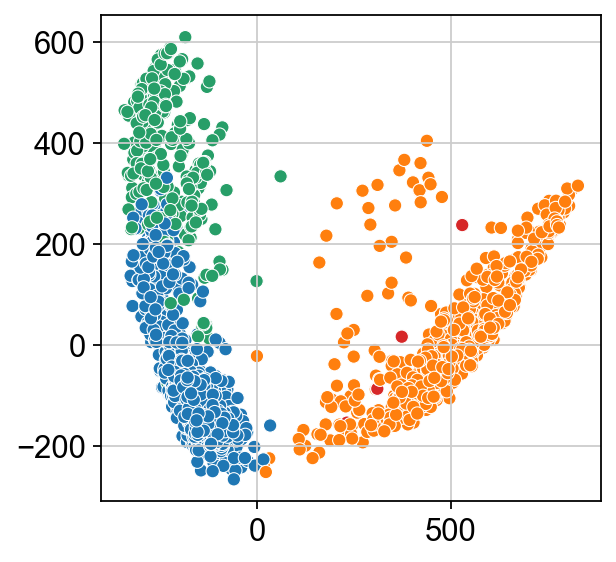

In [66]:
sns.scatterplot(x=X_projected_truncated[:,0],y=X_projected_truncated[:,1],hue=adata.obs['leiden'], legend = False)

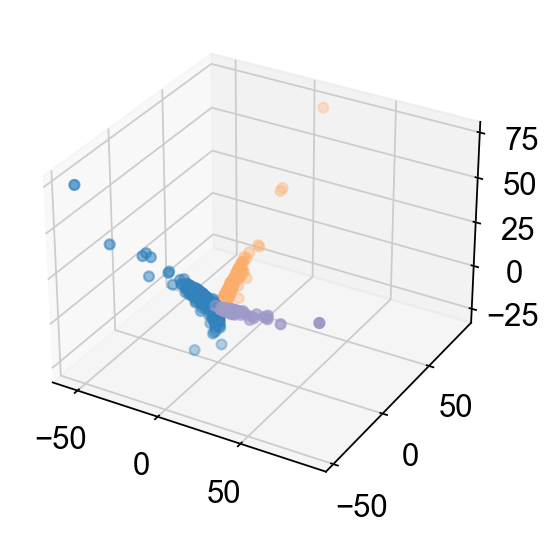

In [53]:
# three D plot
pca = PCA(n_components=3)
X_projected_3d_truncated = pca.fit_transform(contagionMapSingleCellTruncated)

ax = plt.axes(projection='3d')
ax.scatter3D(X_projected_3d_truncated[:,0], X_projected_3d_truncated[:,1], X_projected_3d_truncated[:,2],c=LabelEncoder().fit_transform(adata.obs['leiden'].values),cmap='tab20c')
